In [1]:
from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine
from sqlmodel import Session, select
import pandas as pd
import seaborn as sns
import opinionated
import colormaps as cmaps
import matplotlib.pyplot as plt

plt.style.use("opinionated_rc")

engine = get_engine()

# Create dataset of:
# "document_id", "repository_id",
# "n_doc_contributors", "n_repo_contributors", "n_matched_contributors"
# "publication_date", "cited_by_count", "cited_by_percentile_year_min",
# "field"
data = []
with Session(engine) as session:
    statement = select(
        db_models.DocumentRepositoryLink,
        db_models.Document,
        db_models.Repository,
        db_models.Topic,
    ).join(
        db_models.Document,
    ).join(
        db_models.Repository,
    ).join(
        db_models.DocumentTopic,
    ).join(
        db_models.Topic,
    )

    # For each one, we need to get count of contributors for document and repository
    for link, document, repository, topic in session.exec(statement):
        # Create and exec doc statement
        doc_contrib_statement = select(db_models.DocumentContributor).where(
            db_models.DocumentContributor.document_id == document.id
        )
        doc_contribs = list(session.exec(doc_contrib_statement))
        doc_contribs_lut = {contrib.id: contrib for contrib in doc_contribs}

        # Create and exec repo statement
        repo_contrib_statement = select(db_models.RepositoryContributor).where(
            db_models.RepositoryContributor.repository_id == repository.id
        )
        repo_contribs = list(session.exec(repo_contrib_statement))
        repo_contribs_lut = {contrib.id: contrib for contrib in repo_contribs}

        # For each doc contrib, check if linked to repo contrib
        matched_contribs = []
        for doc_contrib in doc_contribs:
            for repo_contrib in repo_contribs:
                this_doc_contrib_repo_contribs_statement = select(
                    db_models.ResearcherDeveloperAccountLink
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.researcher_id
                        == doc_contrib.researcher_id
                    )
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.developer_account_id
                        == repo_contrib.developer_account_id
                    )
                )
                matched_contrib = session.exec(this_doc_contrib_repo_contribs_statement).first()
                if matched_contrib:
                    matched_contribs.append(matched_contrib)

        # Calc all n_contribs
        n_doc_contributors = len(doc_contribs)
        n_repo_contributors = len(repo_contribs)
        n_matched_contributors = len(matched_contribs)

        # Append to data
        data.append(
            {
                "document_id": document.id,
                "repository_id": repository.id,
                "n_doc_contributors": n_doc_contributors,
                "n_repo_contributors": n_repo_contributors,
                "n_matched_contributors": n_matched_contributors,
                "publication_date": document.publication_date,
                "cited_by_count": document.cited_by_count,
                "cited_by_percentile_year_min": document.cited_by_percentile_year_min,
                "field": topic.field_name,
            }
        )

data = pd.DataFrame(data)

# Drop duplicates by document_id
data = data.drop_duplicates(subset=["document_id"])

data.head()

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

,document_id,repository_id,n_doc_contributors,n_repo_contributors,n_matched_contributors,publication_date,cited_by_count,cited_by_percentile_year_min,field
0,7,1,3,1,1,2023-09-06,2,89,Social Sciences
3,4,2,3,1,1,2022-12-16,8,93,"Biochemistry, Genetics and Molecular Biology"
6,8,3,5,1,1,2020-10-02,71,98,Engineering
9,3,4,11,1,0,2019-01-04,57,98,Medicine
12,2,5,5,5,2,2014-11-13,175,99,Medicine


## Contributors Counts over Time

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/3378306175.py:36: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.lineplot(
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/3378306175.py:36: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  ax = sns.lineplot(


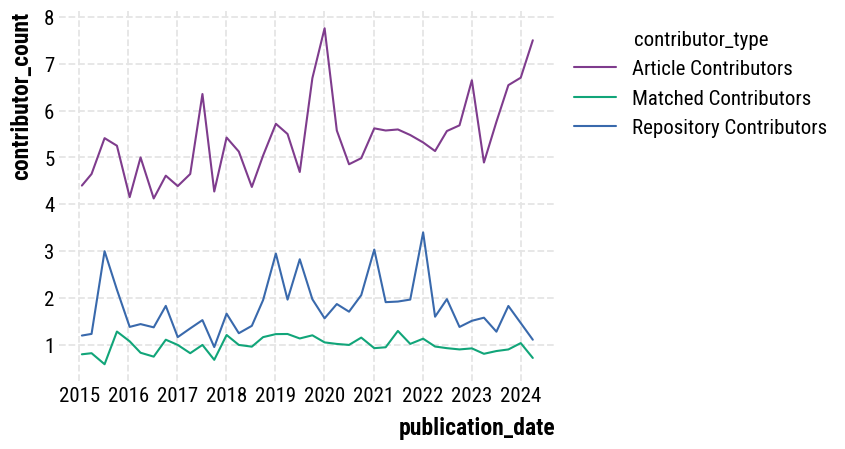

In [2]:
# Subset and melt the different n_doc_contributors, n_repo_contributors, n_matched_contributors
contribs_by_time = data[[
    "document_id",
    "field",
    "publication_date",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
]]
contribs_by_time = pd.melt(
    contribs_by_time,
    id_vars=["document_id", "field", "publication_date"],
    value_vars=["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"],
    var_name="contributor_type",
    value_name="contributor_count",
)
contribs_by_time["contributor_type"] = contribs_by_time.contributor_type.replace({
    "n_doc_contributors": "Article Contributors",
    "n_repo_contributors": "Repository Contributors",
    "n_matched_contributors": "Matched Contributors",
})

# Create column for year-quarter
contribs_by_time["publication_date"] = pd.to_datetime(contribs_by_time["publication_date"])
contribs_by_time["quarter"] = contribs_by_time["publication_date"].dt.to_period("Q")

# Drop anything before 2015
contribs_by_time = contribs_by_time[contribs_by_time["quarter"] >= "2015"]

# Groupby year-month and contributor type
contribs_by_time = contribs_by_time.groupby(["quarter", "contributor_type"]).agg({
    "publication_date": "min",
    "contributor_count": "mean",
}).reset_index()

ax = sns.lineplot(
    data=contribs_by_time,
    x="publication_date",
    y="contributor_count",
    hue="contributor_type",
    palette=cmaps.bold._colors,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Contributor Counts over Time (by Field)

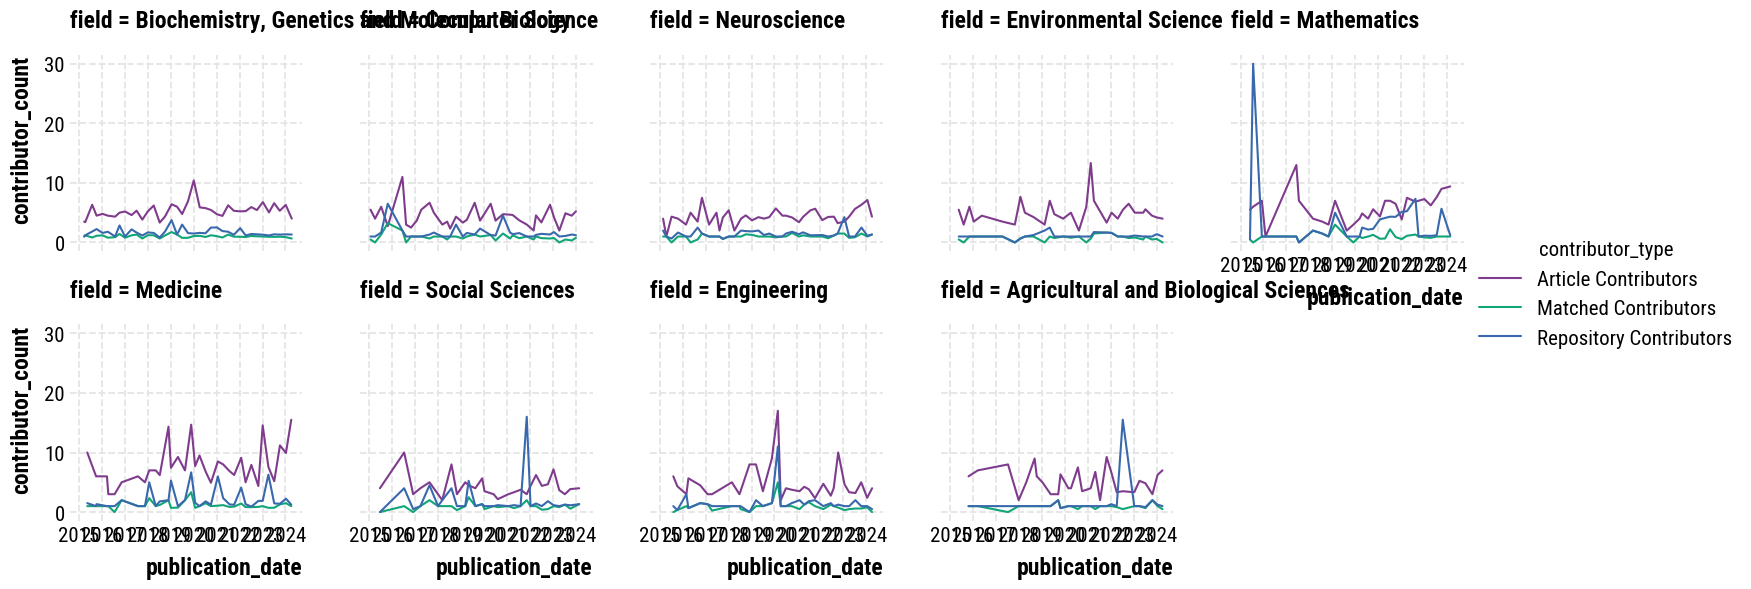

In [3]:
# Subset and melt the different n_doc_contributors, n_repo_contributors, n_matched_contributors
contribs_by_time = data[[
    "document_id",
    "field",
    "publication_date",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
]]

# Drop any fields which have less than 50 documents
field_counts = contribs_by_time.groupby("field").size()
fields_to_drop = field_counts[field_counts < 50].index
contribs_by_time = contribs_by_time[~contribs_by_time.field.isin(fields_to_drop)]

contribs_by_time = pd.melt(
    contribs_by_time,
    id_vars=["document_id", "field", "publication_date"],
    value_vars=["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"],
    var_name="contributor_type",
    value_name="contributor_count",
)
contribs_by_time["contributor_type"] = contribs_by_time.contributor_type.replace({
    "n_doc_contributors": "Article Contributors",
    "n_repo_contributors": "Repository Contributors",
    "n_matched_contributors": "Matched Contributors",
})

# Create column for year-quarter
contribs_by_time["publication_date"] = pd.to_datetime(contribs_by_time["publication_date"])
contribs_by_time["quarter"] = contribs_by_time["publication_date"].dt.to_period("Q")

# Drop anything before 2015
contribs_by_time = contribs_by_time[contribs_by_time["quarter"] >= "2015"]

# Groupby year-month and contributor type
contribs_by_time = contribs_by_time.groupby(["quarter", "field", "contributor_type"]).agg({
    "publication_date": "min",
    "contributor_count": "mean",
}).reset_index()

sns.FacetGrid(
    data=contribs_by_time,
    col="field",
    col_wrap=5,
    hue="contributor_type",
    palette=cmaps.bold._colors,
).map(
    sns.lineplot,
    "publication_date",
    "contributor_count",
).add_legend()

## Contributor Counts by Field

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/2448635124.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.catplot(
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/2448635124.py:28: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.catplot(


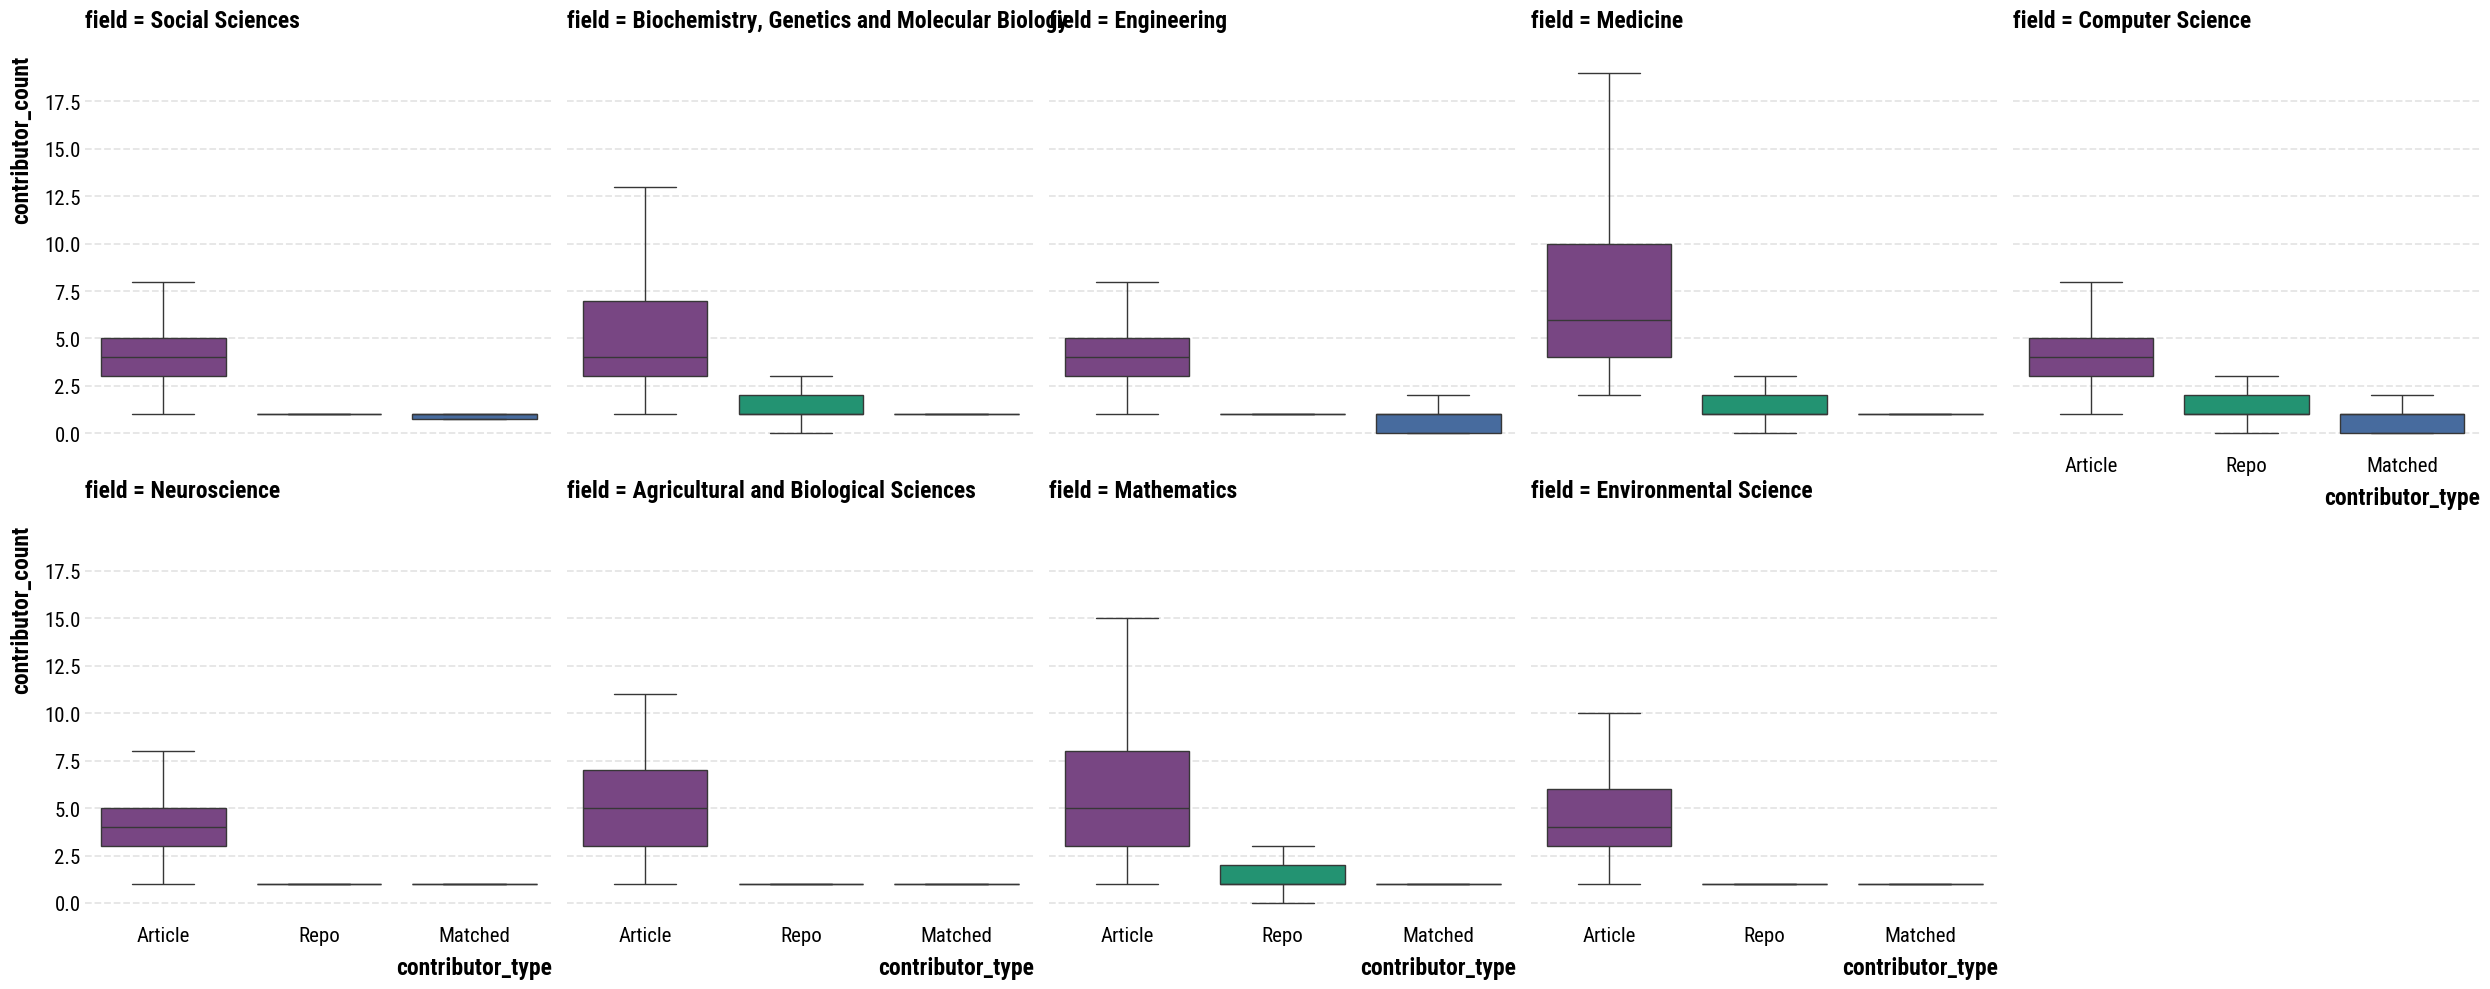

In [4]:
# Subset and melt the different n_doc_contributors, n_repo_contributors, n_matched_contributors
contribs_by_field = data[[
    "document_id",
    "field",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
]]

# Drop any fields which have less than 50 documents
field_counts = contribs_by_field.groupby("field").size()
fields_to_drop = field_counts[field_counts < 50].index
contribs_by_field = contribs_by_field[~contribs_by_field.field.isin(fields_to_drop)]

contribs_by_field = pd.melt(
    contribs_by_field,
    id_vars=["document_id", "field"],
    value_vars=["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"],
    var_name="contributor_type",
    value_name="contributor_count",
)
contribs_by_field["contributor_type"] = contribs_by_field.contributor_type.replace({
    "n_doc_contributors": "Article",
    "n_repo_contributors": "Repo",
    "n_matched_contributors": "Matched",
})

sns.catplot(
    data=contribs_by_field,
    col="field",
    col_wrap=5,
    x="contributor_type",
    y="contributor_count",
    hue="contributor_type",
    palette=cmaps.bold._colors,
    kind="box",
    showfliers=False,
)

## Contributor Counts by Field Ranked Citations

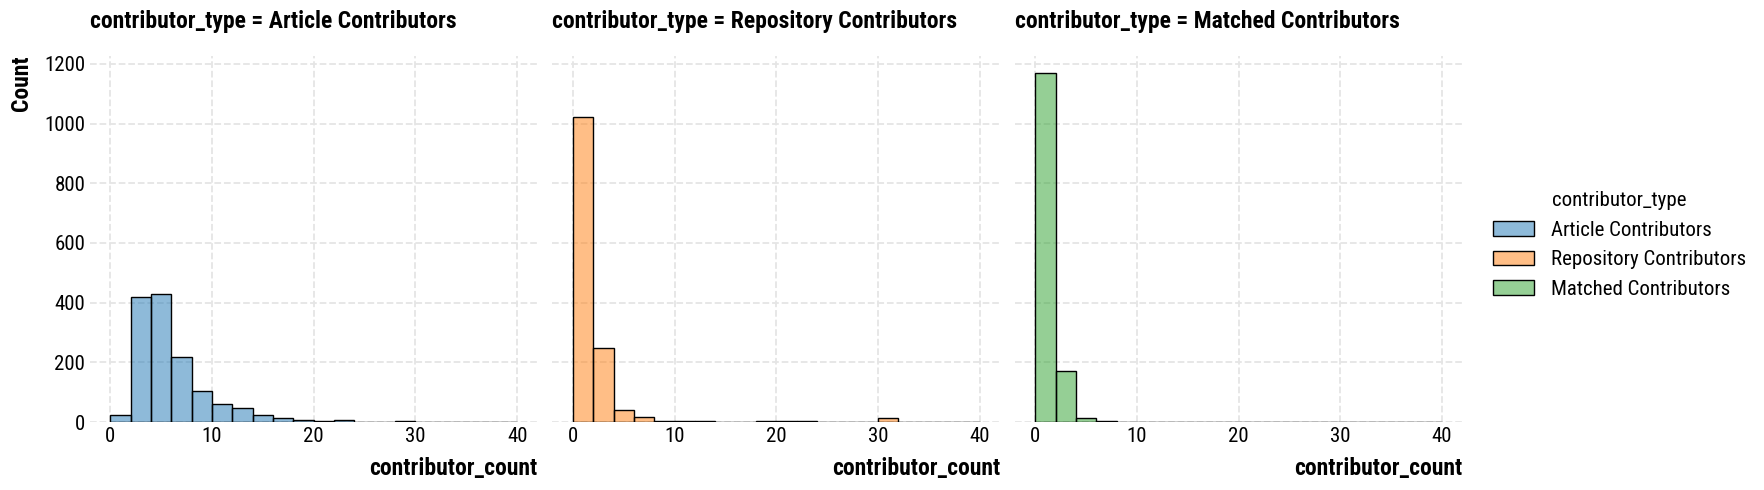

In [5]:
import statsmodels.api as sm
from scipy.stats import zscore

# Get contribs by citations
contribs_by_citations = data[[
    "document_id",
    "field",
    "cited_by_count",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
]].copy()

# Remove bottom and top 5% of cited_by_count
contribs_by_citations = contribs_by_citations[
    (contribs_by_citations["cited_by_count"] > contribs_by_citations["cited_by_count"].quantile(0.05))
    & (contribs_by_citations["cited_by_count"] < contribs_by_citations["cited_by_count"].quantile(0.95))
]

# Melt the contributors
melted_contribs_by_citations_dist_check = pd.melt(
    contribs_by_citations,
    id_vars=["document_id", "field", "cited_by_count"],
    value_vars=["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"],
    var_name="contributor_type",
    value_name="contributor_count",
)

# Rename the contributor types
melted_contribs_by_citations_dist_check["contributor_type"] = melted_contribs_by_citations_dist_check.contributor_type.replace({
    "n_doc_contributors": "Article Contributors",
    "n_repo_contributors": "Repository Contributors",
    "n_matched_contributors": "Matched Contributors",
})

# Show histgram of number of contributors which cols and hue by contributor type
sns.displot(
    data=melted_contribs_by_citations_dist_check,
    x="contributor_count",
    hue="contributor_type",
    col="contributor_type",
    kind="hist",
    bins=20,
)

In [6]:
# Get quantile for all metrics
contribs_by_citations["cited_by_count"] = contribs_by_citations.groupby("field")["cited_by_count"].transform(zscore)
contribs_by_citations["n_doc_contributors"] = contribs_by_citations.groupby("field")["n_doc_contributors"].transform(zscore)
contribs_by_citations["n_repo_contributors"] = contribs_by_citations.groupby("field")["n_repo_contributors"].transform(zscore)
contribs_by_citations["n_matched_contributors"] = contribs_by_citations.groupby("field")["n_matched_contributors"].transform(zscore)

contribs_by_citations

,document_id,field,cited_by_count,n_doc_contributors,n_repo_contributors,n_matched_contributors
0,7,Social Sciences,-0.611689,-0.542677,-0.247686,0.055663
3,4,"Biochemistry, Genetics and Molecular Biology",-0.403356,-0.668675,-0.254609,-0.048210
9,3,Medicine,3.526918,0.633050,-0.275013,-1.410863
15,1,"Biochemistry, Genetics and Molecular Biology",0.649566,-0.415678,-0.254609,-0.048210
18,6,Computer Science,-0.883826,0.181378,-0.329475,-1.379324
...,...,...,...,...,...,...
5049,2353,"Biochemistry, Genetics and Molecular Biology",-0.684135,-0.921673,-0.254609,-0.048210
5052,1768,"Biochemistry, Genetics and Molecular Biology",-0.473551,-0.415678,1.154836,2.086795
5062,1573,"Biochemistry, Genetics and Molecular Biology",-0.754330,-0.415678,-0.254609,-0.048210
5068,2365,Neuroscience,-0.477837,3.408753,-0.301854,-0.080812


In [7]:
model_subset = contribs_by_citations[["cited_by_count", "n_doc_contributors", "n_repo_contributors", "n_matched_contributors"]].dropna()

# Fit glm model
model = sm.GLM(
    model_subset["cited_by_count"],
    model_subset[["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"]],
    data=contribs_by_citations,
    family=sm.families.Gamma(),
)
result = model.fit()
result.summary()

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)
/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:812: RuntimeWarning: invalid value encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         cited_by_count   No. Observations:                 1352
Model:                            GLM   Df Residuals:                     1349
Model Family:                   Gamma   Df Model:                            2
Link Function:           InversePower   Scale:                          1.0022
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 19 Apr 2024   Deviance:                       94758.
Time:                        16:34:13   Pearson chi2:                 1.35e+03
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
n_doc_contributors     -6.689e-18   9.15e-20    -73.085      0.000   -6.87e-18   -6.51e-18
n_repo_contributors     9.034e-18   1.24e-19     73.094      0.000    8.79e-18    9.28e-18
n_matched_contributors -1.308e-18   1.82e-20    -72.063      0.000   -1.34e-18   -1.27e-18
==========================================================================================
"""

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/466773875.py:18: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_1370/466773875.py:18: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='contributor_count', ylabel='cited_by_count'>

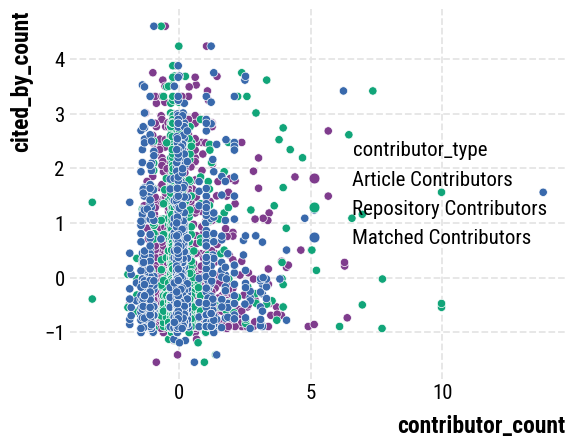

In [8]:
# Melt the contributors
melted_contribs_by_citations = pd.melt(
    contribs_by_citations,
    id_vars=["document_id", "field", "cited_by_count"],
    value_vars=["n_doc_contributors", "n_repo_contributors", "n_matched_contributors"],
    var_name="contributor_type",
    value_name="contributor_count",
)

# Rename the contributor types
melted_contribs_by_citations["contributor_type"] = melted_contribs_by_citations.contributor_type.replace({
    "n_doc_contributors": "Article Contributors",
    "n_repo_contributors": "Repository Contributors",
    "n_matched_contributors": "Matched Contributors",
})

# Plot
sns.scatterplot(
    data=melted_contribs_by_citations,
    x="contributor_count",
    y="cited_by_count",
    hue="contributor_type",
    palette=cmaps.bold._colors,
)